In [14]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime as dtdt 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline


folder='./data'
file='/US_treasury.csv'
warnings.filterwarnings('ignore')

In [15]:
df_raw=pd.read_csv(folder+file)
df_raw.Date=pd.to_datetime(df_raw.Date)
df_raw.set_index('Date',inplace=True, drop=True)
df_raw.dropna(inplace=True,how='any')
df_raw.tail()

,30,90,180,270,365,730,1095,1460,1825,2190,...,4745,5110,5475,5840,6205,6570,6935,7300,9125,10950
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-19,0.019384,0.024059,0.028565,0.030848,0.031998,0.032936,0.032719,0.032417,0.032145,0.031825,...,0.029453,0.030063,0.030907,0.031916,0.033000,0.034061,0.035011,0.035752,0.035331,0.030798
2022-07-20,0.019399,0.024370,0.028899,0.030935,0.031992,0.032878,0.032670,0.032435,0.032222,0.031923,...,0.029322,0.029898,0.030725,0.031725,0.032806,0.033874,0.034812,0.035546,0.035110,0.030602
2022-07-21,0.019116,0.024413,0.028648,0.030444,0.031131,0.031323,0.030942,0.030611,0.030377,0.030113,...,0.027977,0.028615,0.029501,0.030557,0.031688,0.032795,0.033765,0.034521,0.034033,0.029492
2022-07-22,0.020017,0.024478,0.028304,0.029867,0.030335,0.030029,0.029541,0.029182,0.028963,0.028731,...,0.026780,0.027453,0.028382,0.029474,0.030644,0.031791,0.032806,0.033603,0.033273,0.028810
2022-07-25,0.019922,0.024702,0.028685,0.030258,0.030743,0.030489,0.029981,0.029600,0.029384,0.029180,...,0.027393,0.028079,0.029007,0.030102,0.031275,0.032419,0.033429,0.034223,0.033861,0.029344


In [16]:
df_X=df_raw-df_raw.shift(1)
df_X.dropna(inplace=True)

### Obtaining the PCA's 
n_components=3
pca = PCA(n_components=n_components)
pca.fit(df_X)

# Reformat and view results
PCA_loadings = pd.DataFrame(pca.components_.T,
                   columns=['PC%s' % _ for _ in range(n_components)],
                   index=df_X.columns.astype(int))

In [17]:
df_pca_explanation=pd.DataFrame(np.array([pca.explained_variance_ratio_,pca.explained_variance_ratio_.cumsum()]),
                                index=['%Variation explained','%Variation explained (cumulative)'],
                                columns=['PC%s' % _ for _ in range(n_components)])

In [18]:
def ou_param_est_regress(x,delta_t,scale_t=True):
    '''
    Discretizing the OU process we arrive to an AR(1) process
    
    x[i]=a + b x[i-1] + epsilon
    
    from which we can find a, b and the stdev(epsilon)
    
    Thus, it can be shown that 
    
    kappa_1 = -log(b)
    theta = a/(1-b)
    sigma_1 = stdev(epsilon) * sqrt(-2* log(b)/(1-b**2))
    
    Which need to be scaled by delta_t
    
    kappa=kappa_1/delta_t
    sigma_1=sigma/sqrt(delta_t)
    
    '''
    x=np.array(x)
    dfx=pd.DataFrame(x,columns=['X'])
    autocorr=float(dfx.corrwith(dfx.shift(1),drop=True).values)
    stdevy=float(dfx.iloc[1::].std())
    stdevx=float(dfx.iloc[0:-1].std())
    b=float(autocorr*stdevy/stdevx)
    a=float(dfx.iloc[1::].mean()-b*dfx.iloc[0:-1].mean())
    theta_est=a/(1-b)
    kappa_est=-np.log(b)
    sigma_est=np.std(dfx.iloc[1::].values-(a+b*dfx.iloc[0:-1].values))*np.sqrt(-2*np.log(b)/(1-b**2))
    if scale_t:
        kappa_est=kappa_est/(delta_t)
        sigma_est=sigma_est/np.sqrt(delta_t)
    return theta_est,kappa_est,sigma_est

In [19]:
def ou_BM_corr_param_known(x_matrix,theta_vec,kappa_vec,delta_t):
    '''
    It obtains the correlation matrix of Brownian motions of multiple OU processes
    
    It assume that x_matrix rows=dates columns=different OU's

    The OU processes:
    dX1_t = kappa1(theta1 -X1_0)dt + sigma1*dB1_t,  X1_0=x1
    dX2_t = kappa2(theta2 -X2_0)dt + sigma2*dB2_t,  X2_0=x2
    
    with corr(B1_t,B2_t)=rho
    
    Since OU processes can be represented by AR(1) processes, 
    
    x[i]=a + b x[i-1] + epsilon
    
    from which we can find a, b and the stdev(epsilon)
    
    Thus, it can be shown that 
    
    kappa = -log(b)
    theta = a/(1-b)
    sigma = stdev(epsilon) * sqrt(-2* log(b)/(1-b**2))
    
    Which need to be scaled by delta_t
    
    kappa=kappa_1/delta_t
    sigma_1=sigma/sqrt(delta_t)
    
    Similarly, 
    
    b=e^{-kappa * delta_t}
    a=theta*(1-b)
    
    Hence, 
    
    epsilon_1 = x1[i] - (a1+ b1* x1[i-1])  is a vector of residuals for X1
    epsilon_2 = x2[i] - (a2+ b2* x2[i-1])  is a vector of residuals for X2
    
    such that 
    rho=corr(epsilon_1,epsilon_2)    
    '''
    x_matrix=np.array(x_matrix)
    x_after=x_matrix[1::,:]
    x_before=x_matrix[0:-1,:]
    
    a_vec=np.array([theta_vec[i]*(1-np.exp(-kappa_vec[i]*delta_t)) for i in range(len(theta_vec))])
    b_vec=np.array([np.exp(-kappa_vec[i]*delta_t) for i in range(len(theta_vec))])    
    
    eps_matrix=[x_after[:,i]-( a_vec[i] + b_vec[i]*x_before[:,i]) for i in range(len(theta_vec))]
    
    return np.corrcoef(eps_matrix)

In [21]:
def multi_ou_sim_seq(x0_vec,theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t,Nsteps):
    '''
    This provide a single multivariate OU random sample PATH. 
    ___________________
    
    Since the multivariate OU process X_t has the multivariate normal distribution N(Mu_t,Sigma_t)
    where Mu_t and Sigma_t depend on the initial state. 
    
    Mu_t=(mu^1_t,...,mu^n_t)
    Sigma_t = (sigma^1_t,...,sigma^n_t) * C * (sigma^1_t,...,sigma^n_t).T 
    
    with:
    mu^i_t= x^i*exp(-kappa^i* delta_t) +theta^i *(1-exp(-kappa^i *delta_t))
    sigma^i_t^2= (sigma^i)^2/(2*kappa^i)*(1-exp(-2*kappa^i*delta_t))
    C=corr_mat Correlation matrix of Brownian motions.
    
    to generate a sample path, we need to iterate through time 
    considering the sample obtained from the previous step.

    '''
    xvec=np.zeros((Nsteps,len(x0_vec)))
    xvec[0]=x0_vec
    for i in range(1,Nsteps):
        xvec[i]=multi_ou_sim_iter(xvec[i-1],theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t)[0]
    return xvec


def multi_ou_sim_iter(x0_vec,theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t):
    '''
    This provide a single multivariate OU random sample. 
    ___________________
    
    Since the multivariate OU process X_t has the multivariate normal distribution N(Mu_t,Sigma_t)
    where Mu_t and Sigma_t depend on the initial state. 
    
    Mu_t=(mu^1_t,...,mu^n_t)
    Sigma_t = (sigma^1_t,...,sigma^n_t) * C * (sigma^1_t,...,sigma^n_t).T 
    
    with:
    mu^i_t= x^i*exp(-kappa^i* delta_t) +theta^i *(1-exp(-kappa^i *delta_t))
    sigma_i       Instantaneous volatility of Brownian motions
    {C_t}_{i,j}=corr_mat_{i,j} (1 -e^{-(kappa^i +kappa^j)t}/(kappa^i +\kappa^j)   where corr_mat Correlation matrix of Brownian motions.
    
    to generate a sample path, we need to iterate through time 
    considering the sample obtained from the previous step.

    '''
    corr_mat=np.array(corr_mat)
    
    Mu=np.array([ x0_vec[i]*np.exp(-kappa_vec[i]*delta_t) + theta_vec[i]*(1-np.exp(-kappa_vec[i]*delta_t)) for i in range(len(x0_vec))])
    corr_mat_t=np.array([[corr_mat[i,j]*(1-np.exp(-(kappa_vec[i]+kappa_vec[j])*delta_t))/((kappa_vec[i]+kappa_vec[j]))
                           for i in range(len(x0_vec))]
                            for j in range(len(x0_vec))])
    
    Sigma=(np.diag(sigma_vec)).dot(corr_mat_t).dot(np.diag(sigma_vec))
    
    return np.random.multivariate_normal(mean=Mu,cov=Sigma,size=1)

In [22]:
delta_t=1/365
params=[ou_param_est_regress(x=df_raw.loc[:,i],delta_t=delta_t,scale_t=True) for i in df_raw.columns]
df_params=pd.DataFrame(params,columns=['theta','kappa','sigma'],index=df_raw.columns)
df_params

,theta,kappa,sigma
30,0.004163,0.777191,0.009432
90,0.004898,0.698216,0.008733
180,0.005909,0.634560,0.008444
270,0.006673,0.602122,0.008299
365,0.007274,0.587567,0.008205
730,0.009710,0.682678,0.009517
1095,0.012284,0.791884,0.010482
1460,0.014875,0.924972,0.011385
1825,0.017166,0.985980,0.011672
2190,0.019163,0.982389,0.011676


,30,90,180,270,365,730,1095,1460,1825,2190,...,4745,5110,5475,5840,6205,6570,6935,7300,9125,10950
30,1.000000,0.961019,0.902084,0.869764,0.804065,0.547305,0.455781,0.414487,0.377404,0.343844,...,0.235898,0.230913,0.226395,0.222613,0.219292,0.214279,0.210268,0.207239,0.198197,0.136755
90,0.961019,1.000000,0.980976,0.951512,0.886139,0.629866,0.533386,0.486912,0.444707,0.405957,...,0.277927,0.271719,0.266223,0.261605,0.257484,0.251608,0.246594,0.242431,0.229981,0.164387
180,0.902084,0.980976,1.000000,0.988021,0.936986,0.709417,0.614685,0.564949,0.519050,0.476259,...,0.333057,0.325348,0.318536,0.312663,0.307063,0.300119,0.293686,0.287957,0.272024,0.201495
270,0.869764,0.951512,0.988021,1.000000,0.972727,0.792092,0.702909,0.651356,0.603338,0.557998,...,0.400822,0.391412,0.383170,0.376002,0.368938,0.361104,0.353466,0.346553,0.328574,0.247540
365,0.804065,0.886139,0.936986,0.972727,1.000000,0.884715,0.804314,0.751151,0.701838,0.655029,...,0.484348,0.473152,0.463281,0.454766,0.446127,0.437251,0.428190,0.419773,0.398171,0.299729
730,0.547305,0.629866,0.709417,0.792092,0.884715,1.000000,0.970262,0.926911,0.883369,0.839400,...,0.655163,0.639695,0.626398,0.614696,0.602507,0.592383,0.581005,0.570134,0.547486,0.424541
1095,0.455781,0.533386,0.614685,0.702909,0.804314,0.970262,1.000000,0.984461,0.955667,0.920245,...,0.751646,0.735988,0.722047,0.709469,0.696835,0.685726,0.673491,0.661364,0.639841,0.505019
1460,0.414487,0.486912,0.564949,0.651356,0.751151,0.926911,0.984461,1.000000,0.990147,0.964913,...,0.812278,0.796712,0.782633,0.770133,0.757646,0.746257,0.733635,0.720529,0.703577,0.577259
1825,0.377404,0.444707,0.519050,0.603338,0.701838,0.883369,0.955667,0.990147,1.000000,0.990486,...,0.859714,0.845177,0.832125,0.820825,0.809556,0.799393,0.787867,0.775470,0.758683,0.607890
2190,0.343844,0.405957,0.476259,0.557998,0.655029,0.839400,0.920245,0.964913,0.990486,1.000000,...,0.899226,0.886326,0.875045,0.865549,0.856099,0.847992,0.838502,0.827783,0.808330,0.611473


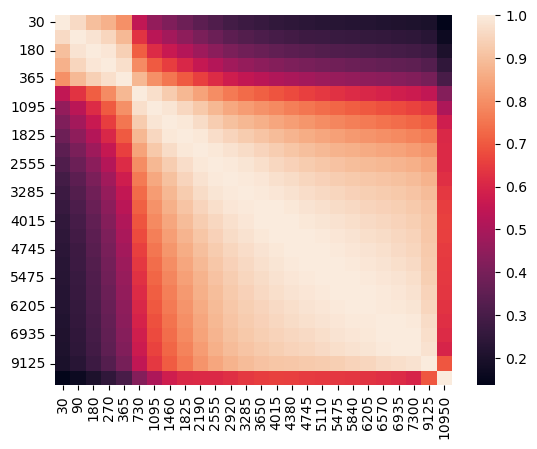

In [25]:
x_matrix=df_raw.values
theta_vec=df_params.loc[:,'theta'].values
kappa_vec=df_params.loc[:,'kappa'].values

correl=ou_BM_corr_param_known(x_matrix=x_matrix,theta_vec=theta_vec,kappa_vec=kappa_vec,delta_t=delta_t)
df_correl=pd.DataFrame(correl,index=df_raw.columns,columns=df_raw.columns)
sns.heatmap(df_correl)
df_correl

In [29]:
x0_vec=df_raw.iloc[-1].values
theta_vec=df_params.loc[:,'theta'].values
kappa_vec=df_params.loc[:,'kappa'].values
sigma_vec=df_params.loc[:,'sigma'].values
corr_mat=df_correl.values
Nsteps=365*3
delta_t=1/365
simul=multi_ou_sim_seq(x0_vec,theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t,Nsteps)
df_simul=pd.DataFrame(simul,columns=df_raw.columns)
df_simul.head()

,30,90,180,270,365,730,1095,1460,1825,2190,...,4745,5110,5475,5840,6205,6570,6935,7300,9125,10950
0,0.019922,0.024702,0.028685,0.030258,0.030743,0.030489,0.029981,0.029600,0.029384,0.029180,...,0.027393,0.028079,0.029007,0.030102,0.031275,0.032419,0.033429,0.034223,0.033861,0.029344
1,0.020200,0.025021,0.029003,0.030575,0.031189,0.031097,0.030590,0.030169,0.029951,0.029698,...,0.027595,0.028275,0.029198,0.030271,0.031461,0.032597,0.033610,0.034394,0.034162,0.029940
2,0.019271,0.024235,0.028329,0.030016,0.030699,0.030847,0.030520,0.030153,0.029932,0.029614,...,0.027641,0.028342,0.029246,0.030329,0.031489,0.032557,0.033497,0.034270,0.033939,0.030107
3,0.019351,0.024454,0.028611,0.030316,0.031139,0.031577,0.031263,0.030802,0.030501,0.030135,...,0.027954,0.028591,0.029406,0.030428,0.031488,0.032530,0.033442,0.034235,0.033918,0.029946
4,0.019143,0.024173,0.028341,0.030049,0.030810,0.031144,0.030721,0.030244,0.029964,0.029676,...,0.027467,0.028073,0.028874,0.029878,0.030991,0.032004,0.032931,0.033766,0.033684,0.030125


In [30]:
simul.shape

(1095, 26)

In [33]:
## Upload the transition matrix
transition = pd.read_csv(folder + "/TransitionMatrix.csv",
                        index_col = 'Rating')
transition.head()

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,CCC,CC,C,Default
Rating,,,,,,,,,,,,,,,,,,,,
AAA,0.920139,0.045587,0.025332,0.003312,0.002923,0.001365,0.000601,0.000200,0.000048,0.000029,0.000197,0.000198,0.000017,0.000011,0.000005,0.000002,0.000006,0.000004,3.494000e-07,0.000023
AA+,0.023336,0.800809,0.094879,0.056927,0.014628,0.005001,0.000868,0.002215,0.000642,0.000145,0.000331,0.000060,0.000026,0.000029,0.000008,0.000004,0.000024,0.000014,1.354400e-06,0.000052
AA,0.012314,0.043279,0.780826,0.102266,0.034955,0.017877,0.005185,0.000731,0.000605,0.000231,0.000419,0.000407,0.000075,0.000206,0.000032,0.000018,0.000263,0.000203,9.794100e-06,0.000097
AA-,0.001019,0.012659,0.044102,0.788125,0.099860,0.037996,0.008012,0.002480,0.002771,0.001771,0.000286,0.000205,0.000305,0.000153,0.000053,0.000013,0.000048,0.000009,9.875000e-07,0.000132
A+,0.000363,0.001089,0.011010,0.053836,0.797749,0.089424,0.027468,0.007988,0.002783,0.001695,0.002188,0.001817,0.000485,0.000969,0.000491,0.000085,0.000339,0.000020,2.693600e-06,0.000198


In [34]:
trans_cum = transition.cumsum(axis=1)
trans_cum.head()

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,CCC,CC,C,Default
Rating,,,,,,,,,,,,,,,,,,,,
AAA,0.920139,0.965726,0.991058,0.994370,0.997294,0.998659,0.999260,0.999459,0.999507,0.999537,0.999734,0.999932,0.999949,0.999960,0.999965,0.999967,0.999973,0.999977,0.999977,1.0
AA+,0.023336,0.824145,0.919024,0.975951,0.990579,0.995580,0.996448,0.998664,0.999306,0.999451,0.999782,0.999842,0.999867,0.999896,0.999905,0.999909,0.999933,0.999947,0.999948,1.0
AA,0.012314,0.055594,0.836420,0.938686,0.973641,0.991518,0.996704,0.997435,0.998040,0.998271,0.998690,0.999097,0.999172,0.999378,0.999409,0.999428,0.999690,0.999893,0.999903,1.0
AA-,0.001019,0.013679,0.057780,0.845905,0.945765,0.983761,0.991773,0.994253,0.997024,0.998796,0.999082,0.999286,0.999591,0.999744,0.999797,0.999810,0.999858,0.999867,0.999868,1.0
A+,0.000363,0.001452,0.012461,0.066297,0.864046,0.953470,0.980938,0.988926,0.991709,0.993404,0.995592,0.997409,0.997894,0.998864,0.999355,0.999440,0.999779,0.999799,0.999802,1.0


In [36]:
## Upload the credit spread
cspread = pd.read_csv(folder + '/credit_spreads.csv',
                     index_col = 'Rating')
cspread.head()

,365,730,1095,1460,1825,2190,2555,2920,3285,3650
Rating,,,,,,,,,,
AAA,0.000023,0.000029,0.000036,0.000046,0.000057,0.000070,0.000084,0.000101,0.000119,0.000138
AA+,0.000052,0.000067,0.000088,0.000112,0.000140,0.000170,0.000203,0.000239,0.000278,0.000320
AA,0.000097,0.000182,0.000243,0.000292,0.000335,0.000377,0.000420,0.000464,0.000512,0.000563
AA-,0.000132,0.000158,0.000195,0.000240,0.000292,0.000350,0.000415,0.000484,0.000559,0.000638
A+,0.000198,0.000286,0.000379,0.000476,0.000576,0.000679,0.000785,0.000893,0.001005,0.001120


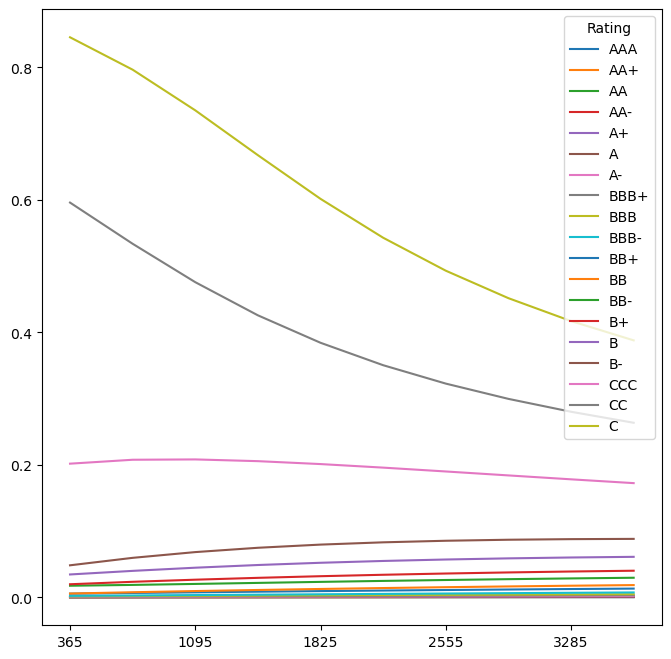

In [56]:
cspread.transpose().plot(figsize = (8, 8))
plt.show()

## 2. Transition Probabilities

### 2.1

In [57]:
# 1

transition_3_year = np.matmul(np.matmul(transition, transition),transition)
prob_1 = transition_3_year.loc['BB', 'C']*100
print("The probability for BB bond become C bond in three years is {}%".format(prob_1))

The probability for BB bond become C bond in three years is 0.07901143526502032%


In [58]:
# 2

default_prob = 0
year = 1
tran_in_year = transition
while default_prob <= 0.01:
    tran_in_year = np.matmul(tran_in_year, transition)
    default_prob = tran_in_year.loc['A','Default']
    year += 1
    print(default_prob)
print()
print("The minimum number of year for the probability of A bond to default is {}".format(year))

0.0009897336266611483
0.0018471725695219676
0.0029569582320166914
0.004329209417689594
0.0059762580374327
0.007911063932175314
0.010145790509255348

The minimum number of year for the probability of A bond to default is 8


In [60]:
# 3

transition_4_year = np.matmul(np.matmul(np.matmul(transition,transition),transition),transition)
prob_3 = sum(transition_4_year.loc['B','AAA':'BBB'])*100
print("The probability for a B bond to become an investment grade bond in four years is {}%".format(prob_3))

The probability for a B bond to become an investment grade bond in four years is 1.1858843642187928%


## 3. Pricing Corporate Bonds

### 3.1

In [61]:
# Display the interest rate data frame
df_raw.tail()

,30,90,180,270,365,730,1095,1460,1825,2190,...,4745,5110,5475,5840,6205,6570,6935,7300,9125,10950
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-19,0.019384,0.024059,0.028565,0.030848,0.031998,0.032936,0.032719,0.032417,0.032145,0.031825,...,0.029453,0.030063,0.030907,0.031916,0.033000,0.034061,0.035011,0.035752,0.035331,0.030798
2022-07-20,0.019399,0.024370,0.028899,0.030935,0.031992,0.032878,0.032670,0.032435,0.032222,0.031923,...,0.029322,0.029898,0.030725,0.031725,0.032806,0.033874,0.034812,0.035546,0.035110,0.030602
2022-07-21,0.019116,0.024413,0.028648,0.030444,0.031131,0.031323,0.030942,0.030611,0.030377,0.030113,...,0.027977,0.028615,0.029501,0.030557,0.031688,0.032795,0.033765,0.034521,0.034033,0.029492
2022-07-22,0.020017,0.024478,0.028304,0.029867,0.030335,0.030029,0.029541,0.029182,0.028963,0.028731,...,0.026780,0.027453,0.028382,0.029474,0.030644,0.031791,0.032806,0.033603,0.033273,0.028810
2022-07-25,0.019922,0.024702,0.028685,0.030258,0.030743,0.030489,0.029981,0.029600,0.029384,0.029180,...,0.027393,0.028079,0.029007,0.030102,0.031275,0.032419,0.033429,0.034223,0.033861,0.029344


In [62]:
cspread.head(10)

,365,730,1095,1460,1825,2190,2555,2920,3285,3650
Rating,,,,,,,,,,
AAA,0.000023,0.000029,0.000036,0.000046,0.000057,0.000070,0.000084,0.000101,0.000119,0.000138
AA+,0.000052,0.000067,0.000088,0.000112,0.000140,0.000170,0.000203,0.000239,0.000278,0.000320
AA,0.000097,0.000182,0.000243,0.000292,0.000335,0.000377,0.000420,0.000464,0.000512,0.000563
AA-,0.000132,0.000158,0.000195,0.000240,0.000292,0.000350,0.000415,0.000484,0.000559,0.000638
A+,0.000198,0.000286,0.000379,0.000476,0.000576,0.000679,0.000785,0.000893,0.001005,0.001120
A,0.000377,0.000495,0.000616,0.000740,0.000868,0.000999,0.001135,0.001275,0.001419,0.001568
A-,0.000517,0.000654,0.000796,0.000947,0.001106,0.001273,0.001448,0.001630,0.001818,0.002011
BBB+,0.001124,0.001293,0.001480,0.001685,0.001903,0.002133,0.002372,0.002619,0.002872,0.003128
BBB,0.001595,0.001902,0.002232,0.002577,0.002931,0.003291,0.003652,0.004014,0.004374,0.004730


In [63]:
def bond_value(tm, Rt, rec, m, t):
    ind = True
    if t == 0:
        rate = df_raw.iloc[-1].loc[str(tm)]
        cred_s = cspread.loc[str(Rt),str(tm)]
        price = m*np.exp(-rate*(tm/365))*(1*np.exp(-cred_s*(tm/365))+ rec*(1-1*np.exp(-cred_s*(tm/365))))
    else:
        dt = tm-t*365
        rate = df_raw.iloc[-1].loc[str(dt)]
        discount_rate = df_raw.iloc[-1].loc[str(365*t)]
        if Rt == "Default":
            price = np.exp(-discount_rate*(t*365)/365)*m*np.exp(-rate*((dt)/365))*rec
        else:
            cred_s = cspread.loc[str(Rt), str(dt)]
            price = np.exp(-discount_rate*(t*365)/365)*m*np.exp(-rate*((dt)/365))*(ind*np.exp(-cred_s*((dt)/365))+ 
                    rec*(1-ind*np.exp(-cred_s*((dt)/365))))
        
    return price

### 1

In [64]:
# bond a
bond_a = bond_value(1095, 'B+', 0.7, 100, 0)
print("The value of bond a today is {}.".format(bond_a))

The value of bond a today is 89.29763830097062.


In [65]:
# bond b
bond_b = bond_value(1825, 'A-', 0.6, 100, 0)
print("The value of bond a today is {}.".format(bond_b))

The value of bond a today is 86.14609983063555.


In [66]:
# bond c
bond_c = bond_value(3650, 'AA', 0.5, 100, 0)
print("The value of bond a today is {}.".format(bond_c))

The value of bond a today is 75.92581242002018.


In [67]:
# to confirm the correct answer

port_today = bond_a+bond_b+bond_c
port_today

251.36955055162633

### 2

In [68]:
bond_a2 = bond_value(1095, 'B+', 0.7, 100, 1)
print("The value of bond a in one year today is {}.".format(bond_a2))

The value of bond a in one year today is 89.98555813255507.


In [69]:
bond_b2 = bond_value(1825, 'A-', 0.6, 100, 1)
print("The value of bond b in one year today is {}.".format(bond_b2))

The value of bond b in one year today is 86.01432510616148.


In [70]:
bond_c2 = bond_value(3650, 'AA', 0.5, 100, 1)
print("The value of bond c in one year today is {}.".format(bond_c2))

The value of bond c in one year today is 75.35106958089688.


In [71]:
# Confirm the correct answer

bond_a2+bond_b2+bond_c2

251.35095281961344

### 3

In [72]:
bond_a3 = bond_value(1095, 'BB', 0.7, 100, 1)
print("The value of bond a in one year today is {}.".format(bond_a3))

The value of bond a in one year today is 90.82167340000883.


In [73]:
bond_b3 = bond_value(1825, 'Default', 0.6, 100, 1)
print("The value of bond B in one year today is {}.".format(bond_b3))

The value of bond B in one year today is 51.68673861969427.


In [74]:
bond_c3 = bond_value(3650, 'AAA', 0.5, 100, 1)
print("The value of bond c in one year today is {}.".format(bond_c3))

The value of bond c in one year today is 75.48436584795172.


In [75]:
print("The value of the portfolio today is {}".format(bond_a3+bond_b3+bond_c3))

The value of the portfolio today is 217.9927778676548


## 4 Value at Risk and Expected Shortfall

In [82]:
# generate one sample path for interest rate
x0_vec=df_raw.iloc[-1].values
theta_vec=df_params.loc[:,'theta'].values
kappa_vec=df_params.loc[:,'kappa'].values
sigma_vec=df_params.loc[:,'sigma'].values
corr_mat=df_correl.values
Nsteps=2
delta_t=2
simul=multi_ou_sim_seq(x0_vec,theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t,Nsteps)
df_simul=pd.DataFrame(simul,columns=df_raw.columns)
df_simul

,30,90,180,270,365,730,1095,1460,1825,2190,...,4745,5110,5475,5840,6205,6570,6935,7300,9125,10950
0,0.019922,0.024702,0.028685,0.030258,0.030743,0.030489,0.029981,0.02960,0.029384,0.029180,...,0.027393,0.028079,0.029007,0.030102,0.031275,0.032419,0.033429,0.034223,0.033861,0.029344
1,0.016892,0.020036,0.022584,0.023300,0.022838,0.017622,0.018990,0.02061,0.021294,0.021939,...,0.027446,0.028554,0.029594,0.030508,0.031088,0.031682,0.031775,0.031323,0.032424,0.041738


In [83]:
t_mat = np.matmul(transition,transition)
t_mat_cum = t_mat.cumsum(axis=1)
t_mat_cum.head(10)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,CCC,CC,C,Default
Rating,,,,,,,,,,,,,,,,,,,,
AAA,0.848037,0.927632,0.975233,0.986251,0.993242,0.996684,0.998119,0.998704,0.998911,0.999034,0.999415,0.999773,0.999835,0.999877,0.999897,0.999906,0.999930,0.999942,0.999943,1.0
AA+,0.041396,0.688602,0.841956,0.943038,0.975788,0.989025,0.992362,0.996475,0.998049,0.998597,0.999246,0.999467,0.999573,0.999684,0.999724,0.999743,0.999823,0.999862,0.999865,1.0
AA,0.022089,0.092445,0.711540,0.876590,0.943726,0.979366,0.990901,0.993648,0.995516,0.996380,0.997262,0.998041,0.998303,0.998715,0.998834,0.998908,0.999363,0.999612,0.999636,1.0
AA-,0.002649,0.024849,0.096564,0.728764,0.891108,0.961350,0.980402,0.987113,0.992955,0.996454,0.997448,0.998148,0.998783,0.999225,0.999421,0.999487,0.999652,0.999680,0.999683,1.0
A+,0.000918,0.003885,0.024218,0.111855,0.759448,0.905404,0.957639,0.975407,0.982974,0.987132,0.991167,0.994378,0.995628,0.997419,0.998384,0.998688,0.999356,0.999416,0.999428,1.0
A,0.001492,0.002577,0.011516,0.032946,0.124098,0.756111,0.892266,0.945397,0.974090,0.984282,0.989651,0.992964,0.995052,0.996649,0.997491,0.997869,0.998909,0.998992,0.999010,1.0
A-,0.000283,0.001382,0.003186,0.008061,0.034674,0.139909,0.776297,0.904369,0.958957,0.979713,0.988016,0.990969,0.993734,0.996115,0.997140,0.997863,0.998506,0.998672,0.998693,1.0
BBB+,0.000274,0.000922,0.002214,0.004162,0.009501,0.037013,0.151819,0.785202,0.915980,0.962030,0.976179,0.983486,0.987229,0.992850,0.994499,0.995913,0.997176,0.997386,0.997418,1.0
BBB,0.000981,0.001803,0.003035,0.004892,0.009122,0.025144,0.063829,0.176637,0.804305,0.921259,0.954347,0.969877,0.979423,0.985843,0.991069,0.993189,0.995913,0.996154,0.996204,1.0


In [84]:
def get_rating(rating):
    u = np.random.uniform(0,1)
    row = t_mat_cum.loc[rating]
    n = 0
    while u > row[n]:
        n += 1
    
    r = t_mat_cum.columns[n]
    
    return r

In [85]:
# new function for simulation of interest rate

def bond_v(df,tm, Rt, rec, m, t):
    ind = True
    if t == 0:
        rate = df.iloc[-1].loc[str(tm)]
        cred_s = cspread.loc[str(Rt),str(tm)]
        price = m*np.exp(-rate*(tm/365))*(1*np.exp(-cred_s*(tm/365))+ rec*(1-1*np.exp(-cred_s*(tm/365))))
    else:
        dt = tm-t*365
        rate = df.iloc[-1].loc[str(dt)]
        discount_rate = df.iloc[-1].loc[str(365*t)]
        if Rt == "Default":
            price = np.exp(-discount_rate*(t*365)/365)*m*np.exp(-rate*((dt)/365))*rec
        else:
            cred_s = cspread.loc[str(Rt), str(dt)]
            price = np.exp(-discount_rate*(t*365)/365)*m*np.exp(-rate*((dt)/365))*(ind*np.exp(-cred_s*((dt)/365))+ 
                    rec*(1-ind*np.exp(-cred_s*((dt)/365))))
        
    return price

In [86]:
n = 1000
port_v = []
loss_v = []
for i in range(n): 
    # get rating for bond a
    rating_a = get_rating('B+')
    # get rating for bond b
    rating_b = get_rating('A-')
    # get rating for bond c
    rating_c = get_rating('AA')

    # simulate the interest rate
    x0_vec=df_raw.iloc[-1].values
    theta_vec=df_params.loc[:,'theta'].values
    kappa_vec=df_params.loc[:,'kappa'].values
    sigma_vec=df_params.loc[:,'sigma'].values
    corr_mat=df_correl.values
    Nsteps=2
    delta_t=2
    simul=multi_ou_sim_seq(x0_vec,theta_vec,kappa_vec,sigma_vec,corr_mat,delta_t,Nsteps)
    df_simul=pd.DataFrame(simul,columns=df_raw.columns)
    df_simul

    sim_a = bond_v(df_simul, 1095, rating_a, 0.7, 100, 2)
    sim_b = bond_v(df_simul, 1825, rating_b, 0.6, 100, 2)
    sim_c = bond_v(df_simul, 3650, rating_c, 0.5, 100, 2)
    
    portfolio = sim_a + sim_b + sim_c
    loss = -(portfolio - port_today)
    port_v.append(portfolio)
    loss_v.append(loss)

In [89]:
port_sim = pd.DataFrame({'Loss': loss_v, 'Port_v': port_v})

conf=0.99

VaR=port_sim['Loss'].quantile(conf)
ES=port_sim['Loss'].loc[port_sim['Loss']>=VaR].mean()

df_risk=pd.DataFrame([VaR,ES],index=['VaR','ES'],columns=['@'+str(conf*100)+'%'])

print('\n Risk Measures \n')
df_risk


 Risk Measures 



,@99.0%
VaR,23.741306
ES,30.380239
